In [33]:
# Import libraries
import string
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [34]:
# Preprocess before loading into data frame
validchars = string.ascii_letters + string.digits + '\t .!?:()'

with open('data//data.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

processed_lines = []
for line in lines:
    line = line.replace('...', ' ')
    line = line.replace('..', ' ')
    line = line.replace(':)', ' emoji ')
    line = line.replace(':(', ' emoji ')
    line = line.replace(':-)', ' emoji ')
    line = line.replace(':-(', ' emoji ')
    line = re.sub(r'[+-]?((\d+\.?\d*)|(\.\d+))', ' number ', line)
    line = re.sub(r'[$£]+', ' currency ', line)
    line = ''.join(c for c in line if c in validchars)
    if line.startswith('spam'):
        parts = line.split('spam\t')
        if len(parts) == 2:
            text = parts[1]
            text = re.sub(r'\s+', ' ', text)
            processed_line = f"{text.strip()}" + ",0\n"
            processed_lines.append(processed_line) 
        else:
            print(f"Error: {line}")    

    elif line.startswith('ham'):
        parts = line.split('ham\t')
        if len(parts) == 2:
            text = parts[1]
            text = re.sub(r'\s+', ' ', text)
            processed_line = f"{text.strip()}" + ",1\n"
            processed_lines.append(processed_line)
        else:
            print(f"Error: {line}")
    else:
        processed_lines.append(line)
        print(f"Error: {line}")

with open('data//processed_data.csv', 'w', encoding='utf-8') as f:
    f.write("text,label\n")
    f.writelines(processed_lines)

In [35]:
# Read the data
df = pd.read_csv('data//processed_data.csv')

In [36]:
# Display 10 random rows
print(df.shape)
df.tail(10)

(5574, 2)


,text,label
5564,Ok lor Sony ericsson salesman I ask shuhui the...,1
5565,Ard number like dat lor.,1
5566,Why dont you wait til at least wednesday to se...,1
5567,Huh y lei,1
5568,REMINDER FROM O number : To get number pounds ...,0
5569,This is the number nd time we have tried numbe...,0
5570,Will b going to esplanade fr home?,1
5571,Pity was in mood for that. So any other sugges...,1
5572,The guy did some bitching but I acted like id ...,1
5573,Rofl. Its true to its name,1


In [37]:
# There are duplicated rows which may lead to data leakage
# shall drop them as well
print(df.duplicated().sum())
df.groupby('label').describe()

454


text                                                               
      count unique                                                top freq
label                                                                     
0       747    609  PRIVATE! Your number Account Statement for sho...    4
1      4827   4511                               Sorry Ill call later   30

In [38]:
df.drop_duplicates(inplace=True, ignore_index=True) # Drop duplicate rows
print(df.shape)
df.tail(10)

(5120, 2)


,text,label
5110,Ok lor Sony ericsson salesman I ask shuhui the...,1
5111,Ard number like dat lor.,1
5112,Why dont you wait til at least wednesday to se...,1
5113,Huh y lei,1
5114,REMINDER FROM O number : To get number pounds ...,0
5115,This is the number nd time we have tried numbe...,0
5116,Will b going to esplanade fr home?,1
5117,Pity was in mood for that. So any other sugges...,1
5118,The guy did some bitching but I acted like id ...,1
5119,Rofl. Its true to its name,1


In [39]:
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
0       609    609  Free entry in number a wkly comp to win FA Cup...    1
1      4511   4511  Go until jurong point crazy Available only in ...    1

In [40]:
# Calculate the length of each text
df['length'] = df['text'].map(lambda text: len(text))

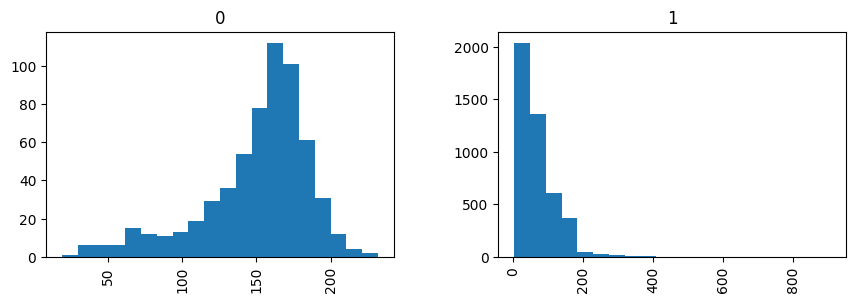

In [41]:
# Distribution of length of text for spam and ham
df.hist(column='length', by='label', bins=20, figsize=(10,3))
plt.show()

In [42]:
def tokenize_and_stem(text):
    """Tokenize and stem the text"""
    tokenizer = RegexpTokenizer(r'\w+')
    snow_stemmer = SnowballStemmer(language='english')
    words = tokenizer.tokenize(text)
    stemmed_words = []
    for w in words:
        if len(w) < 2:
            continue
        stemmed_words.append(snow_stemmer.stem(w))
    return stemmed_words

In [43]:
# Pipeline to implement vectorization and tf-idf transformation
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer=tokenize_and_stem)),
    ('tfidf', TfidfTransformer())
])
corpus = df.text
pipeline.fit(corpus)
corpus_tfidf = pipeline.transform(corpus)

In [44]:
print(f'Shape of transformed matrix: {corpus_tfidf.shape}')
print(f'Number of non-zero: {corpus_tfidf.nnz}')
print(f'Sparsity: {round(100.0*corpus_tfidf.nnz/(corpus_tfidf.shape[0]*corpus_tfidf.shape[1]),3)}%')

Shape of transformed matrix: (5120, 6632)
Number of non-zero: 67057
Sparsity: 0.197%


In [45]:
df_transform = pd.concat([df, pd.DataFrame(corpus_tfidf.toarray())], axis=1)
df_transform.drop('text', axis=1, inplace=True)

In [46]:
# Train, validate and test split
train, remainder = train_test_split(df_transform, train_size=0.8,stratify=df_transform.label)
validate, test = train_test_split(remainder, train_size=0.5, stratify=remainder.label)

In [47]:
# Reset index
train.reset_index(drop=True, inplace=True)
validate.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [48]:
# Dump the data
joblib.dump(train, 'data//train.pkl')
joblib.dump(validate, 'data//validate.pkl')
joblib.dump(test, 'data//test.pkl')

['data//test.pkl']